In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


## **Libraries**

In [2]:
import os
from os import listdir
import pandas as pd
import seaborn as sb
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2

import cv2
import glob
import random
import numpy as np
import cv2
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import pickle

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, MaxPool2D , Flatten, Dense, Activation, Dropout, SpatialDropout2D, ZeroPadding2D, Convolution2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD

import tensorflow as tf

from tensorflow.keras.utils import to_categorical


In [3]:
directory_root = '/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/X-ray/'
default_image_size = tuple((256, 256))

## **Visualization**

In [4]:
#dir_prefix = "COVID-19_Dataset/X-ray/Negative/"
def visualize_XRays(label_folder, directory_root):
  rows = 1
  columns = 6
  count = 1
  print('Visualizing Covid:',label_folder)
  covid_folder_list = listdir(f"{directory_root}/{label_folder}") 
  for image in covid_folder_list: # Execute Negative & Positive folder
    if count>rows*columns:
      break
    image_directory = f"{directory_root}/{label_folder}/{image}"
    fig.add_subplot(rows, columns, count)
    count+=1
    Image = cv2.imread(image_directory)
    plt.imshow(Image, cmap=plt.cm.bone)

In [5]:
root_dir = listdir(f"{directory_root}")

Visualizing Covid: Negative


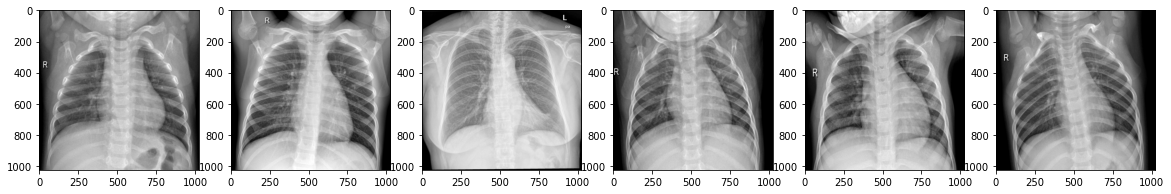

In [6]:
fig = plt.figure(figsize=(20, 10))

visualize_XRays(root_dir[0],directory_root)

Visualizing Covid: Positive


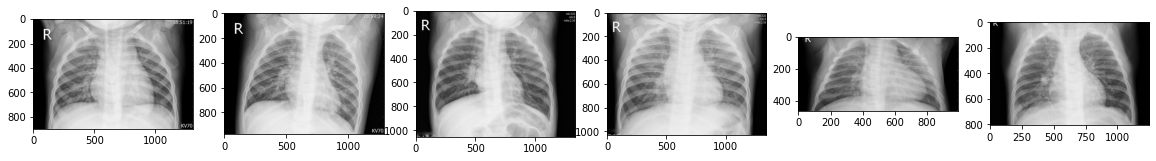

In [7]:
fig = plt.figure(figsize=(20, 10))

visualize_XRays(root_dir[1],directory_root)

## **Processing Image data & setting label**

In [8]:
#Function to convert images to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print("Error :",e)
        return None

In [9]:
image_list, label_list = [], []
count = 0 
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for label_folder in root_dir:
        covid_folder_list = listdir(f"{directory_root}/{label_folder}") 
        print("Processing:",label_folder)
        for image in covid_folder_list[:1500]: # Execute Negative & Positive folder
            count+=1
            #print(f"[INFO] Processing {image} ...")
            #print(label_folder)
            image_directory = f"{directory_root}/{label_folder}/{image}"
            #if image_directory.endswith(".JPG") == True or image_directory.endswith(".JPEG") == True or image_directory.endswith(".PNG") == True or image_directory.endswith(".png") == True:
            image_list.append(convert_image_to_array(image_directory))
            label_list.append(label_folder)
    
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
Processing: Negative
Processing: Positive
Error : [Errno 20] Not a directory: '/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/X-ray//download.jpg'


In [13]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
image_labels_2 = to_categorical(image_labels)
pickle.dump(label_binarizer,open('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Covid-Detection/label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [14]:
print(label_binarizer.classes_)

['Negative' 'Positive']


In [15]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [16]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels_2,#image_labels,
                                                    test_size=0.2, random_state = 42, shuffle=True) 

[INFO] Spliting data to train, test


In [17]:
# Our vectorized labels
# y_train = np.asarray(y_train).astype('int').reshape((-1,1))
# y_test = np.asarray(y_test).astype('int').reshape((-1,1))

In [18]:
print(x_train.shape, y_train.shape, '\n',x_test.shape, y_test.shape)

(2400, 256, 256, 3) (2400, 2) 
 (600, 256, 256, 3) (600, 2)


In [19]:
aug = ImageDataGenerator(
    rotation_range=0,#25, 
    width_shift_range=0.0,#0.1,
    height_shift_range=0.0,#0.1, 
    shear_range=0.0,#0.2, 
    zoom_range=0.0,#0.2,
    horizontal_flip=False,#True, 
    fill_mode="nearest")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


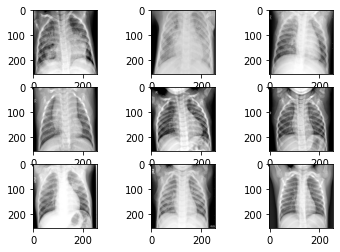

In [20]:
# fit parameters from data
aug.fit(x_train)

# Configure batch size and retrieve one batch of images
for x_batch, y_batch in aug.flow(x_train, y_train, batch_size=32):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i])
    # show the plot
    plt.show()
    break

In [21]:
EPOCHS = 100#50
INIT_LR = 1e-3
BS = 32
#image_size = 0
width=256
height=256
depth=3

### **VGG16 model**

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(input_shape=inputShape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1024,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation="softmax"))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 256)       2

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", 
              optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [ ]:
history_vgg16 = model.fit_generator(aug.flow(x_train,y_train,batch_size=BS),
                                    validation_data= (x_test, y_test),
                                    steps_per_epoch=len(x_train) // BS,
                                    epochs=EPOCHS,
                                    verbose=1)#,callbacks=[checkpoint,early])


Epoch 1/25
50/50 [==============================] - 75s 638ms/step - loss: 0.7174 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 2/25
50/50 [==============================] - 29s 572ms/step - loss: 0.6934 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 3/25
50/50 [==============================] - 28s 565ms/step - loss: 0.6935 - accuracy: 0.4994 - val_loss: 0.6933 - val_accuracy: 0.5025
Epoch 4/25
50/50 [==============================] - 27s 549ms/step - loss: 0.6945 - accuracy: 0.4994 - val_loss: 0.6933 - val_accuracy: 0.5025
Epoch 5/25
50/50 [==============================] - 28s 553ms/step - loss: 0.6937 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 6/25
50/50 [==============================] - 28s 555ms/step - loss: 0.6935 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 7/25
50/50 [==============================] - 27s 550ms/step - loss: 0.6931 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.5025

In [ ]:
print("[INFO] Calculating VGG16 model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating VGG16 model accuracy
13/13 [==============================] - 2s 143ms/step - loss: 0.6931 - accuracy: 0.5025
Test Accuracy: 50.24999976158142


In [ ]:
print("[INFO] Saving VGG16 model H5...")
model.save("/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/VGG16.h5")
print('model saved')

[INFO] Saving VGG16 model H5...
model saved


## **VGG19**

In [ ]:
def VGG_19(weights_path=None):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    #model.add(Convolution2D(input_shape=inputShape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(ZeroPadding2D((1,1),input_shape=inputShape))#(3,224,224)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(1000, activation='softmax'))
    model.add(Dense(units=1, activation="softmax"))
    if weights_path:
        model.load_weights(weights_path)

    return model

In [ ]:
model_vgg_19 = VGG_19()
model_vgg_19.summary()

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model_vgg_19.compile(loss='mean_squared_error',#loss="binary_crossentropy", 
              optimizer=opt,metrics=["accuracy"])
print("[INFO] training network...")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_16 (ZeroPaddi (None, 258, 258, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
zero_padding2d_17 (ZeroPaddi (None, 258, 258, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
zero_padding2d_18 (ZeroPaddi (None, 130, 130, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 128)    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history_vgg19 = model_vgg_19.fit_generator(aug.flow(x_train,y_train,batch_size=BS),
                                    validation_data= (x_test, y_test),
                                    steps_per_epoch=len(x_train) // BS,
                                    epochs=EPOCHS,
                                    verbose=1)#,callbacks=[checkpoint,early])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
50/50 [==============================] - 38s 730ms/step - loss: 0.5006 - accuracy: 0.4994 - val_loss: 0.4975 - val_accuracy: 0.5025
Epoch 2/25
50/50 [==============================] - 36s 723ms/step - loss: 0.5006 - accuracy: 0.4994 - val_loss: 0.4975 - val_accuracy: 0.5025
Epoch 3/25
50/50 [==============================] - 36s 726ms/step - loss: 0.5006 - accuracy: 0.4994 - val_loss: 0.4975 - val_accuracy: 0.5025
Epoch 4/25
50/50 [==============================] - 37s 735ms/step - loss: 0.5006 - accuracy: 0.4994 - val_loss: 0.4975 - val_accuracy: 0.5025
Epoch 5/25
50/50 [==============================] - 36s 730ms/step - loss: 0.5006 - accuracy: 0.4994 - val_loss: 0.4975 - val_accuracy: 0.5025
Epoch 6/25
50/50 [==============================] - 37s 742ms/step - loss: 0.5006 - accuracy: 0.4994 - val_loss: 0.4975 - val_accuracy: 0.5025
Epoch 7/25
50/50 [==============================] - 37s 747ms/step - loss: 0.5006 - accuracy: 0.4994 - val_loss: 0.4975 - val_accuracy: 0.5025

In [ ]:
print("[INFO] Calculating VGG19 model accuracy")
scores_vgg_19 = model_vgg_19.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores_vgg_19[1]*100}")

[INFO] Calculating VGG19 model accuracy
13/13 [==============================] - 2s 181ms/step - loss: 0.4975 - accuracy: 0.5025
Test Accuracy: 50.24999976158142


In [ ]:
print("[INFO] Saving VGG19 model H5...")
model_vgg_19.save("/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/VGG19.h5")
print('model saved')

[INFO] Saving VGG19 model H5...
model saved


## **Custom model**

In [23]:
model_custom = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model_custom.add(Conv2D(32, (3, 3), padding="same",activation="relu",input_shape=inputShape, strides=(1,1)))
#model_custom.add(BatchNormalization(axis=chanDim))
model_custom.add(MaxPooling2D(pool_size=(3, 3)))
#model_custom.add(SpatialDropout2D(0.25))
model_custom.add(Conv2D(64, (3, 3), padding="same",activation="relu", strides=(1,1)))
#model_custom.add(BatchNormalization(axis=chanDim))
model_custom.add(Conv2D(64, (3, 3), padding="same",activation="relu", strides=(1,1)))
#model_custom.add(BatchNormalization(axis=chanDim))
model_custom.add(MaxPooling2D(pool_size=(2, 2)))
#model_custom.add(SpatialDropout2D(0.25))
model_custom.add(Conv2D(128, (3, 3), padding="same",activation="relu", strides=(1,1)))
#model_custom.add(BatchNormalization(axis=chanDim))
model_custom.add(Conv2D(128, (3, 3), padding="same",activation="relu", strides=(1,1)))
#model_custom.add(BatchNormalization(axis=chanDim))
model_custom.add(MaxPooling2D(pool_size=(2, 2)))
#model_custom.add(SpatialDropout2D(0.25))
######################
model_custom.add(Conv2D(512, (3, 3), padding="same",activation="relu", strides=(1,1)))
model_custom.add(Conv2D(512, (3, 3), padding="same",activation="relu", strides=(1,1)))
model_custom.add(Conv2D(512, (3, 3), padding="same",activation="relu", strides=(1,1)))
model_custom.add(MaxPooling2D(pool_size=(2, 2)))
#model_custom.add(SpatialDropout2D(0.25))
#########################
model_custom.add(Flatten())
model_custom.add(Dense(1024, activation="relu"))
#model_custom.add(BatchNormalization())
model_custom.add(Dropout(0.5))
#model_custom.add(Dense(1,activation="sigmoid" ))
model_custom.add(Dense(2,activation="softmax" ))

In [24]:
model_custom.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 85, 85, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 42, 42, 128)       73856     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 42, 42, 128)      

In [25]:
from keras.optimizers import SGD
opt = SGD(lr=INIT_LR)
model_custom.compile(loss='mean_squared_error',#loss ="categorical_crossentropy",#"sparse_categorical_crossentropy",#"binary_crossentropy",
              optimizer = opt,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
print(x_test.shape, x_train.shape)

(600, 256, 256, 3) (2400, 256, 256, 3)


In [27]:
history = model_custom.fit_generator(aug.flow(x_train,y_train,batch_size=BS),
                                    validation_data= (x_test, y_test),
                                     steps_per_epoch=len(x_train) // BS,
                                     epochs=EPOCHS,
                                     verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
75/75 [==============================] - 45s 159ms/step - loss: 0.2497 - accuracy: 0.5304 - val_loss: 0.2493 - val_accuracy: 0.7567
Epoch 2/100
75/75 [==============================] - 9s 123ms/step - loss: 0.2493 - accuracy: 0.5479 - val_loss: 0.2488 - val_accuracy: 0.6900
Epoch 3/100
75/75 [==============================] - 9s 124ms/step - loss: 0.2489 - accuracy: 0.5721 - val_loss: 0.2484 - val_accuracy: 0.6617
Epoch 4/100
75/75 [==============================] - 9s 124ms/step - loss: 0.2485 - accuracy: 0.6067 - val_loss: 0.2481 - val_accuracy: 0.6700
Epoch 5/100
75/75 [==============================] - 9s 125ms/step - loss: 0.2483 - accuracy: 0.6112 - val_loss: 0.2477 - val_accuracy: 0.6417
Epoch 6/100
75/75 [==============================] - 9s 126ms/step - loss: 0.2478 - accuracy: 0.6187 - val_loss: 0.2474 - val_accuracy: 0.6567
Epoch 7/100
75/75 [==============================] - 10s 127ms/step - loss: 0.2477 - accuracy: 0.6296 - val_loss: 0.2471 - val_accuracy: 0.65

## **Accuracy check of Custom model**

In [28]:
print("[INFO] Calculating Custom model accuracy")
scores = model_custom.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating Custom model accuracy
19/19 [==============================] - 1s 43ms/step - loss: 0.0778 - accuracy: 0.9017
Test Accuracy: 90.16666412353516


## **Saving Custom model**

In [29]:
print("[INFO] Saving Custom model H5...")
model_custom.save("/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_7.h5")
#model_custom.save("/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_5.pkl")
print('model saved')

[INFO] Saving Custom model H5...
model saved


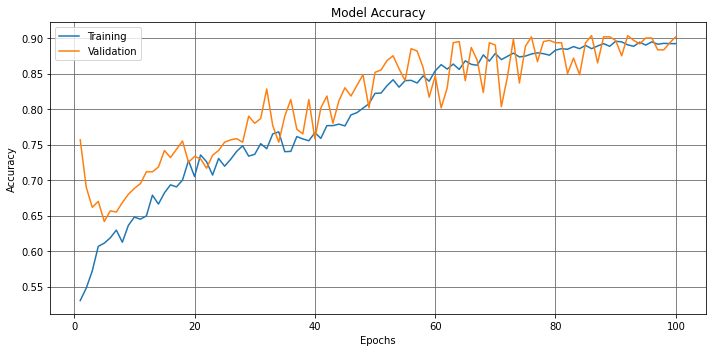

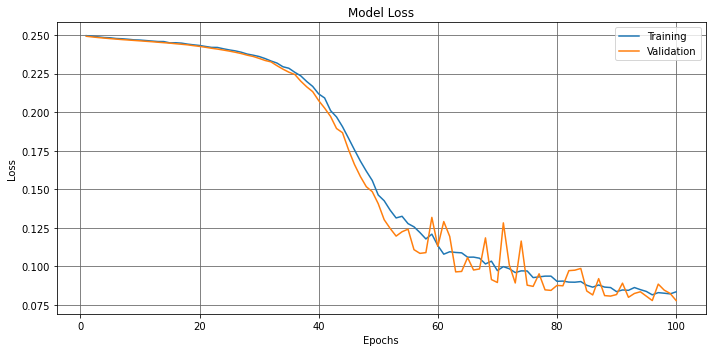

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(500)

# plt.figure(figsize=(15, 15))
# plt.subplot(2, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

## **Saving model with weights & Converting .h5 to .tflite**

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_2.h5')
model.save_weights('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/MyModel',True)

model.load_weights('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/MyModel')
model.save("/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_3.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_3.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpe4s4kqko/assets


INFO:tensorflow:Assets written to: /tmp/tmpe4s4kqko/assets


232350140

In [ ]:
#for heavy model architectures, .h5 file is unsupported.
model = tf.keras.models.load_model('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_2.h5')

weigh= model.get_weights();    
pklfile= "/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom.pkl"

try:
    fpkl= open(pklfile, 'wb')    #Python 3     
    pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()
except:
    fpkl= open(pklfile, 'w')    #Python 2      
    pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()


## **Simple conversion of .h5 to .tflite**

In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_custom)
tflite_model = converter.convert()
open("/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_7.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpymflg3dq/assets


232085616

## **Converting to quantized model**

In [9]:
# Convert the model to quantized version with post-training quantization
model = tf.keras.models.load_model('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_7.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open("/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_Quant_7.tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpv1s1kt9b/assets


58077552

###**Manual Testing of Custom Model**

In [7]:
model_custom = keras.models.load_model('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_2.h5')

In [8]:
#Function to convert images to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print("Error :",e)
        return None

In [9]:
image_list=[]
model_custom = tf.keras.models.load_model('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_2.h5')
default_image_size = tuple((256, 256))

image_list.append(convert_image_to_array('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/X-ray/Positive/bd3ceeb6.png'))
#image_list.append(convert_image_to_array('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/X-ray/download.jpg'))
#image_list.append(convert_image_to_array('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/X-ray/Chest_3.jpg'))
#image_list.append(convert_image_to_array('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/X-ray/Negative/02.jpeg'))
#image_list
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

result = model_custom.predict_classes(np_image_list)
print(type(result))
print(result.ndim)
print(result.shape)
print(result)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<class 'numpy.ndarray'>
1
(1,)
[1]


In [ ]:
result[0]

1

In [ ]:
#